<center
style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:20px; font-size:360%; text-align:center;padding:3.0px; background: black; border-top: 13px solid grey; border-left: 10px solid grey; border-right: -5px solid #17202a"> Diabetes Prediction Challenge <img src="https://www.kaggle.com/competitions/91723/images/header" width="280" style="border: 1px solid #17202a; border-radius: 1px" loading="lazy" />
</center>

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 1. Introduction </p>

<p style="
  font-family: Calibri;
  font-weight: bold;
  letter-spacing: 0.5px;
  color: #A52A2A;
  border-radius: 15px;
  font-size: 140%;
  text-align: left;
  padding: 10px;
  background: k;
  border-bottom: 5px solid black;
  border-left: 10px solid black;
  line-height: 2.;
">
  Let"s use <span style="color:gold;">a lightgbm model</span> to predict the likeliness of a patient to have diabetes. Prior to that, we will explore the data, design visuals then build workflows and models to predict the diagnosis. Let's make it  <span style="color:deepskyblue;">bright</span>, <span style="color:orange;">dynamic</span>, and <span style="color: green;">effective</span>. <span style="color:gold;">  The predictions will then be submitted to s5e12 of the swag competition</span>. <img src="https://lightgbm.readthedocs.io/en/latest/_images/LightGBM_logo_black_text.svg" width="680" style="border: 1px solid #17202a; border-radius: 1px" loading="lazy" />
</p>

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 2. Get the libraries and tools </p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import iqr

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import clone
from sklearn import preprocessing as prepro
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV

import category_encoders as ce

from lightgbm import LGBMClassifier

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

# Define your custom colors
set_colors = ['steelblue', 'orange', '#00FFFF']
target_colors = ['#808080', '#A52A2A']
# Create a seaborn palette
set_palette = sns.color_palette(set_colors)
target_palette = sns.color_palette(target_colors)


# # Set Seaborn theme with dark grid and brighter palette
# sns.set_theme(style="darkgrid", font_scale=0.9)

# Update matplotlib parameters for brighter dark theme
# plt.rcParams.update({
#     'axes.facecolor': 'black',       # Slightly lighter than #222222
#     'figure.facecolor': 'black',
#     'text.color': '#FFA500',           # Bright gold for better contrast
#     'axes.labelcolor': 'gray',      # Softer mint green
#     'xtick.color': 'gray',
#     'ytick.color': 'gray',
#     'grid.color': 'grey',           # Lighter grid lines
#     'axes.edgecolor': '#dddddd',        # Light gray edges
#     'axes.grid': False,
# })

seed=42

# verify the versions
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas version: 2.3.3
numpy version: 1.26.4
seaborn version: 0.13.2


# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 2. Get and preview the datasets </p>

In [2]:
tr_00 = pd.read_csv('../input/playground-series-s5e12/train.csv', index_col='id')
ts_00 = pd.read_csv('../input/playground-series-s5e12/test.csv', index_col='id')
sb_00 = pd.read_csv('../input/playground-series-s5e12/sample_submission.csv')

# external dataset
or_00 = pd.read_csv('../input/diabetes_dataset.csv')[tr_00.columns]

# or_00 = pd.read_csv('')

target = 'diagnosed_diabetes'

tr_00.head(5)

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
id,,,,,,,,,,,,,,,,,,,,,
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [3]:
"""
# Modified for local execution (Antigravity)
import pandas as pd
import os
import numpy as np

# Check file existence
file_path = '../input/diabetes_012_health_indicators_BRFSS2015.csv'
if not os.path.exists(file_path):
    print(f"Error: {file_path} not found! Please ensure data is in input directory.")
else:
    df_full = pd.read_csv(file_path)
    print("Dataset loaded:", df_full.shape)

# Define target (mapped from original 'diagnosed_diabetes' to local 'Diabetes_012')
target = 'Diabetes_012'

# Split into train/test (simulating the competition structure)
from sklearn.model_selection import train_test_split
# Using 80% train, 20% test
tr_00, ts_00 = train_test_split(df_full, test_size=0.2, random_state=42)

# Reset index to simulate 'id' column behavior if needed, or just standard index
tr_00 = tr_00.reset_index(drop=True)
ts_00 = ts_00.reset_index(drop=True)

# Mock external data (just use train data to prevent breakage)
or_00 = pd.read_csv('../input/diabetes_dataset.csv')[tr_00.columns]


# Sample submission simulation
sb_00 = pd.DataFrame(index=ts_00.index)
sb_00['id'] = ts_00.index # Add explicit id column if needed
sb_00[target] = 0.5 

print("Data structures tr_00, ts_00, sb_00, or_00 created.")
tr_00.head(5)
"""


'\n# Modified for local execution (Antigravity)\nimport pandas as pd\nimport os\nimport numpy as np\n\n# Check file existence\nfile_path = \'../input/diabetes_012_health_indicators_BRFSS2015.csv\'\nif not os.path.exists(file_path):\n    print(f"Error: {file_path} not found! Please ensure data is in input directory.")\nelse:\n    df_full = pd.read_csv(file_path)\n    print("Dataset loaded:", df_full.shape)\n\n# Define target (mapped from original \'diagnosed_diabetes\' to local \'Diabetes_012\')\ntarget = \'Diabetes_012\'\n\n# Split into train/test (simulating the competition structure)\nfrom sklearn.model_selection import train_test_split\n# Using 80% train, 20% test\ntr_00, ts_00 = train_test_split(df_full, test_size=0.2, random_state=42)\n\n# Reset index to simulate \'id\' column behavior if needed, or just standard index\ntr_00 = tr_00.reset_index(drop=True)\nts_00 = ts_00.reset_index(drop=True)\n\n# Mock external data (just use train data to prevent breakage)\nor_00 = pd.read_csv(\

In [4]:
or_00.head()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,58,0,215,5.7,7.9,7.9,30.5,0.89,134,78,...,Male,Asian,Highschool,Lower-Middle,Never,Employed,0,0,0,1
1,48,1,143,6.7,6.5,8.7,23.1,0.80,129,76,...,Female,White,Highschool,Middle,Former,Employed,0,0,0,0
2,60,1,57,6.4,10.0,8.1,22.2,0.81,115,73,...,Male,Hispanic,Highschool,Middle,Never,Unemployed,1,0,0,1
3,74,0,49,3.4,6.6,5.2,26.8,0.88,120,93,...,Female,Black,Highschool,Low,Never,Retired,0,0,0,1
4,46,1,109,7.2,7.4,5.0,21.2,0.78,92,67,...,Male,White,Graduate,Middle,Never,Retired,0,0,0,1


# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 3. Explore the datasets </p>

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 3.1 Dataset info and  description </p>

In [5]:
print(f'shape of train set: {tr_00.shape}\
\nshape of test set: {ts_00.shape}\
\nshape of external set: {or_00.shape}')

shape of train set: (700000, 25)
shape of test set: (300000, 24)
shape of external set: (100000, 25)


In [6]:
tr_00.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700000 entries, 0 to 699999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  int64  
 1   alcohol_consumption_per_week        700000 non-null  int64  
 2   physical_activity_minutes_per_week  700000 non-null  int64  
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  int64  
 9   diastolic_bp                        700000 non-null  int64  
 10  heart_rate                          700000 non-null  int64  
 11  cholesterol_total              

In [7]:
for df in [tr_00]:
    df[target] = df[target].astype('int').astype('category')

In [8]:
tr_00.describe().T

,count,mean,std,min,25%,50%,75%,max
age,700000.0,50.359734,11.655520,19.00,42.00,50.00,58.00,89.00
alcohol_consumption_per_week,700000.0,2.072411,1.048189,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,700000.0,80.230803,51.195071,1.00,49.00,71.00,96.00,747.00
diet_score,700000.0,5.963695,1.463336,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,700000.0,7.002200,0.901907,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,700000.0,6.012733,2.022707,0.60,4.60,6.00,7.40,16.50
bmi,700000.0,25.874684,2.860705,15.10,23.90,25.90,27.80,38.40
waist_to_hip_ratio,700000.0,0.858766,0.037980,0.68,0.83,0.86,0.88,1.05
systolic_bp,700000.0,116.294193,11.010390,91.00,108.00,116.00,124.00,163.00
diastolic_bp,700000.0,75.440924,6.825775,51.00,71.00,75.00,80.00,104.00


In [9]:
tr_00.describe(exclude='number').T

,count,unique,top,freq
gender,700000,3,Female,363237
ethnicity,700000,5,White,386153
education_level,700000,4,Highschool,344145
income_level,700000,5,Middle,290557
smoking_status,700000,3,Never,494448
employment_status,700000,4,Employed,516170
diagnosed_diabetes,700000,2,1,436307


In [10]:
bool_feats = [feat for feat in ts_00.select_dtypes('number') if ts_00[feat].nunique()==2]

num_feats = [feat for feat in ts_00.select_dtypes(include='number').columns.tolist()]
num_feats = [feat for feat in num_feats if feat not in bool_feats]


# num_feats = [feat for feat in ts_00.select_dtypes(include='number').columns.tolist() if ts_00[feat].nunique()>5].remove(bool_feats)
cat_feats = ts_00.select_dtypes(exclude='number').columns.tolist() + bool_feats

In [11]:
def plot_num_distribution_grid(df, num_feats=num_feats, grouper=target, palette=target_palette, bins=50, ncols=3):
    """
    Plot histograms + boxplots for numerical features in a grid layout.
    Each feature gets two stacked subplots (hist + box) with boxplot 1/3 height of histplot.
    Both plots share the same x-axis.
    """
    df[target] = df[target].astype('category')
    nrows = int(np.ceil(len(num_feats) / ncols))

    fig = plt.figure(figsize=(ncols*6, nrows*4))
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols, hspace=0.6)

    for i, feat in enumerate(num_feats):
        row = i // ncols
        col = i % ncols

        # Sub-grid with height ratio 3:1 and shared x-axis
        sub_gs = gs[row, col].subgridspec(2, 1, height_ratios=[3, 1])
        ax_hist = fig.add_subplot(sub_gs[0])
        ax_box = fig.add_subplot(sub_gs[1], sharex=ax_hist)

        # Histogram
        # sns.histplot(data=df, x=feat, hue=grouper, bins=bins, kde=True,
        #              palette=palette, multiple="dodge", ax=ax_hist)
        sns.kdeplot(data=df, x=feat, hue=grouper, palette=palette, fill=True, ax=ax_hist)
        ax_hist.set_title(f"{feat} Distribution", fontsize=10, color='white', backgroundcolor='black')
        ax_hist.set_xlabel('')  # Remove x-label from histogram
        ax_hist.tick_params(axis='x', labelbottom=False)  # Hide x-ticks on histogram

        # Boxplot (horizontal to match x-axis)
        sns.boxplot(data=df, x=feat, y=grouper, palette=palette,
                    ax=ax_box,
                    flierprops=dict(marker='o', markerfacecolor='red',
                                    markeredgecolor='black', markersize=3))
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 3.2 Compare distributions in train and test sets </p>

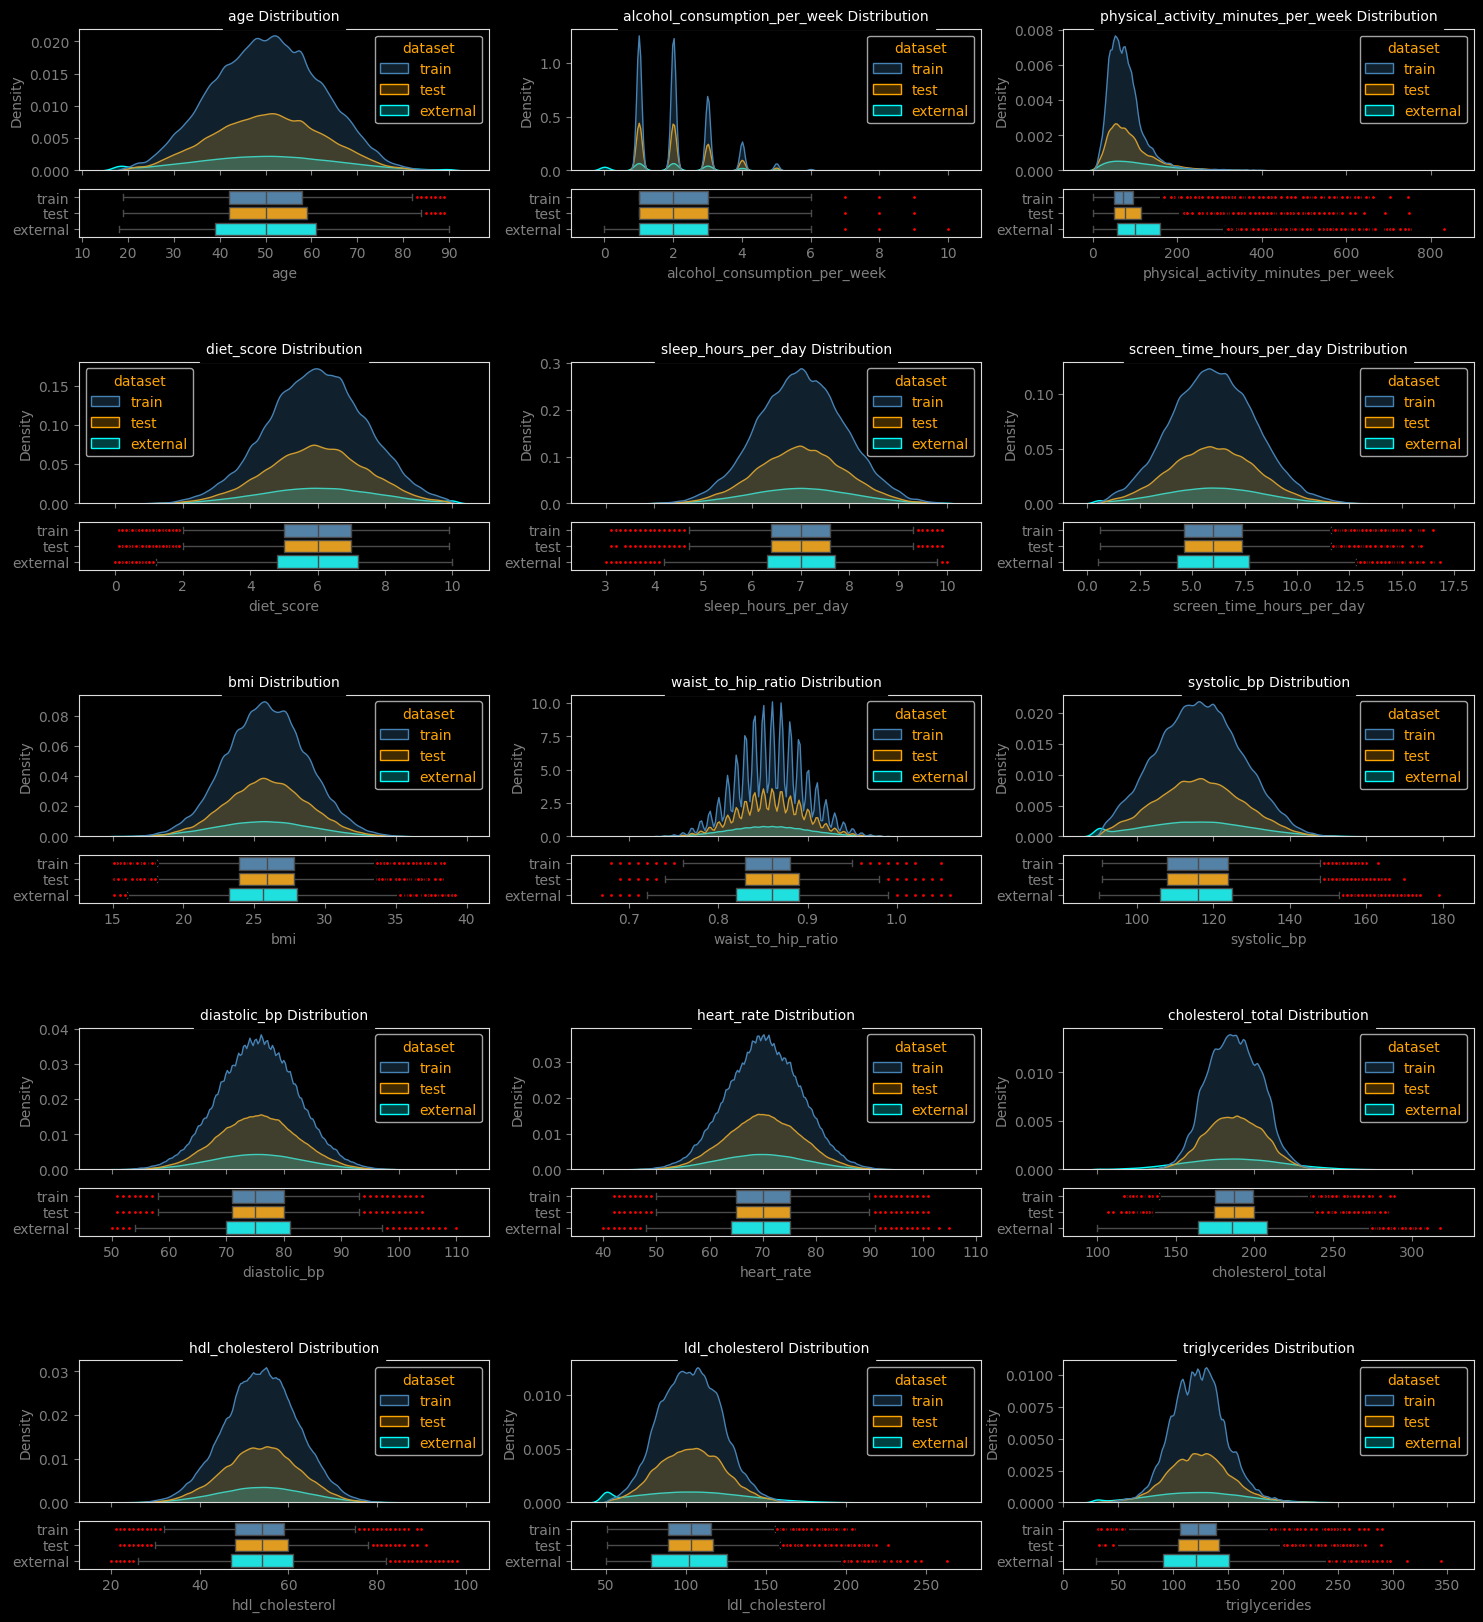

In [12]:
tr_r = tr_00.copy()
ts_r = ts_00.copy()
or_r = or_00.copy()

tr_r['dataset'] = 'train'
ts_r['dataset'] = 'test'
or_r['dataset'] = 'external'

tr_all_sets = pd.concat([tr_r, ts_r, or_r], ignore_index=True)

plot_num_distribution_grid(tr_all_sets, grouper='dataset', palette=set_palette)

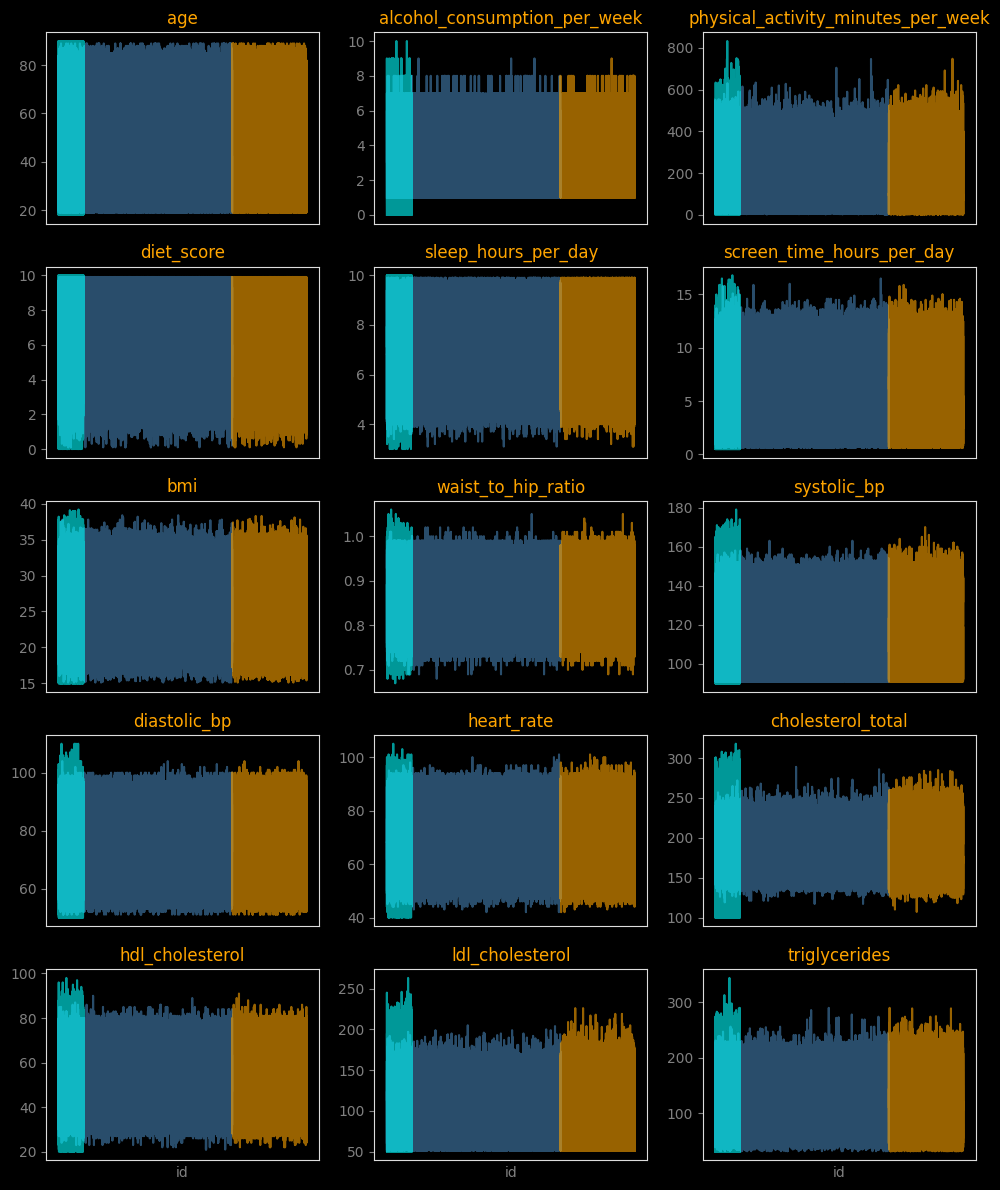

In [13]:
for c, col in enumerate(num_feats, 1):
    plt.subplot(5, 3, c)
    ax = tr_00[col].plot(title=col, figsize=(10, 12), color=set_colors[0], alpha=0.6)
    ts_00[col].plot(color=set_colors[1], ax=ax, alpha=0.6)
    or_00[col].plot(color=set_colors[2], ax=ax, alpha=0.6)
    plt.xticks([])
    if c not in [13, 14, 15]:
        plt.xlabel('')
plt.tight_layout()
plt.show()

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 3.3 Compare distributions when grouped by diagnosis </p>

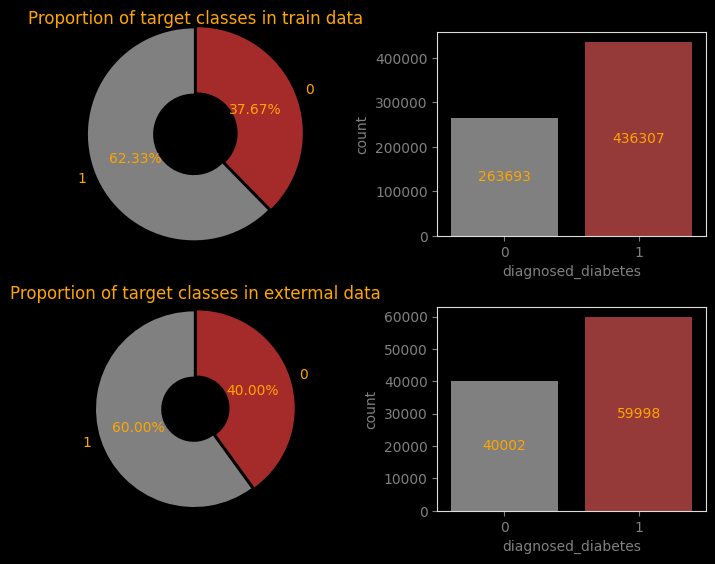

In [14]:
plt.figure(figsize=(7, 6))
plt.subplot(221)
tr_00[target].value_counts().plot.pie(
    radius=1.3,
    autopct='%.2f%%',
    startangle=90,
    wedgeprops={'width': 0.8},
    explode=[0.02, 0.02],
    colors=target_colors,
    title='Proportion of target classes in train data'
)
plt.ylabel('')
plt.subplot(222)
ax1 = sns.countplot(tr_00, x=target, palette=target_colors)
for count in ax1.containers:
    ax1.bar_label(count, label_type='center')
plt.subplot(223)
or_00[target].value_counts().plot.pie(
    radius=1.2,
    autopct='%.2f%%',
    startangle=90,
    wedgeprops={'width': 0.8},
    explode=[0.02, 0.02],
    colors=target_colors,
    title='Proportion of target classes in extermal data'
)
plt.ylabel('')
plt.subplot(224)
ax2=sns.countplot(or_00, x=target, palette=target_colors)
for count in ax2.containers:
    ax2.bar_label(count, label_type='center')
    
plt.tight_layout(pad=2, h_pad=2, w_pad=2)
plt.show()

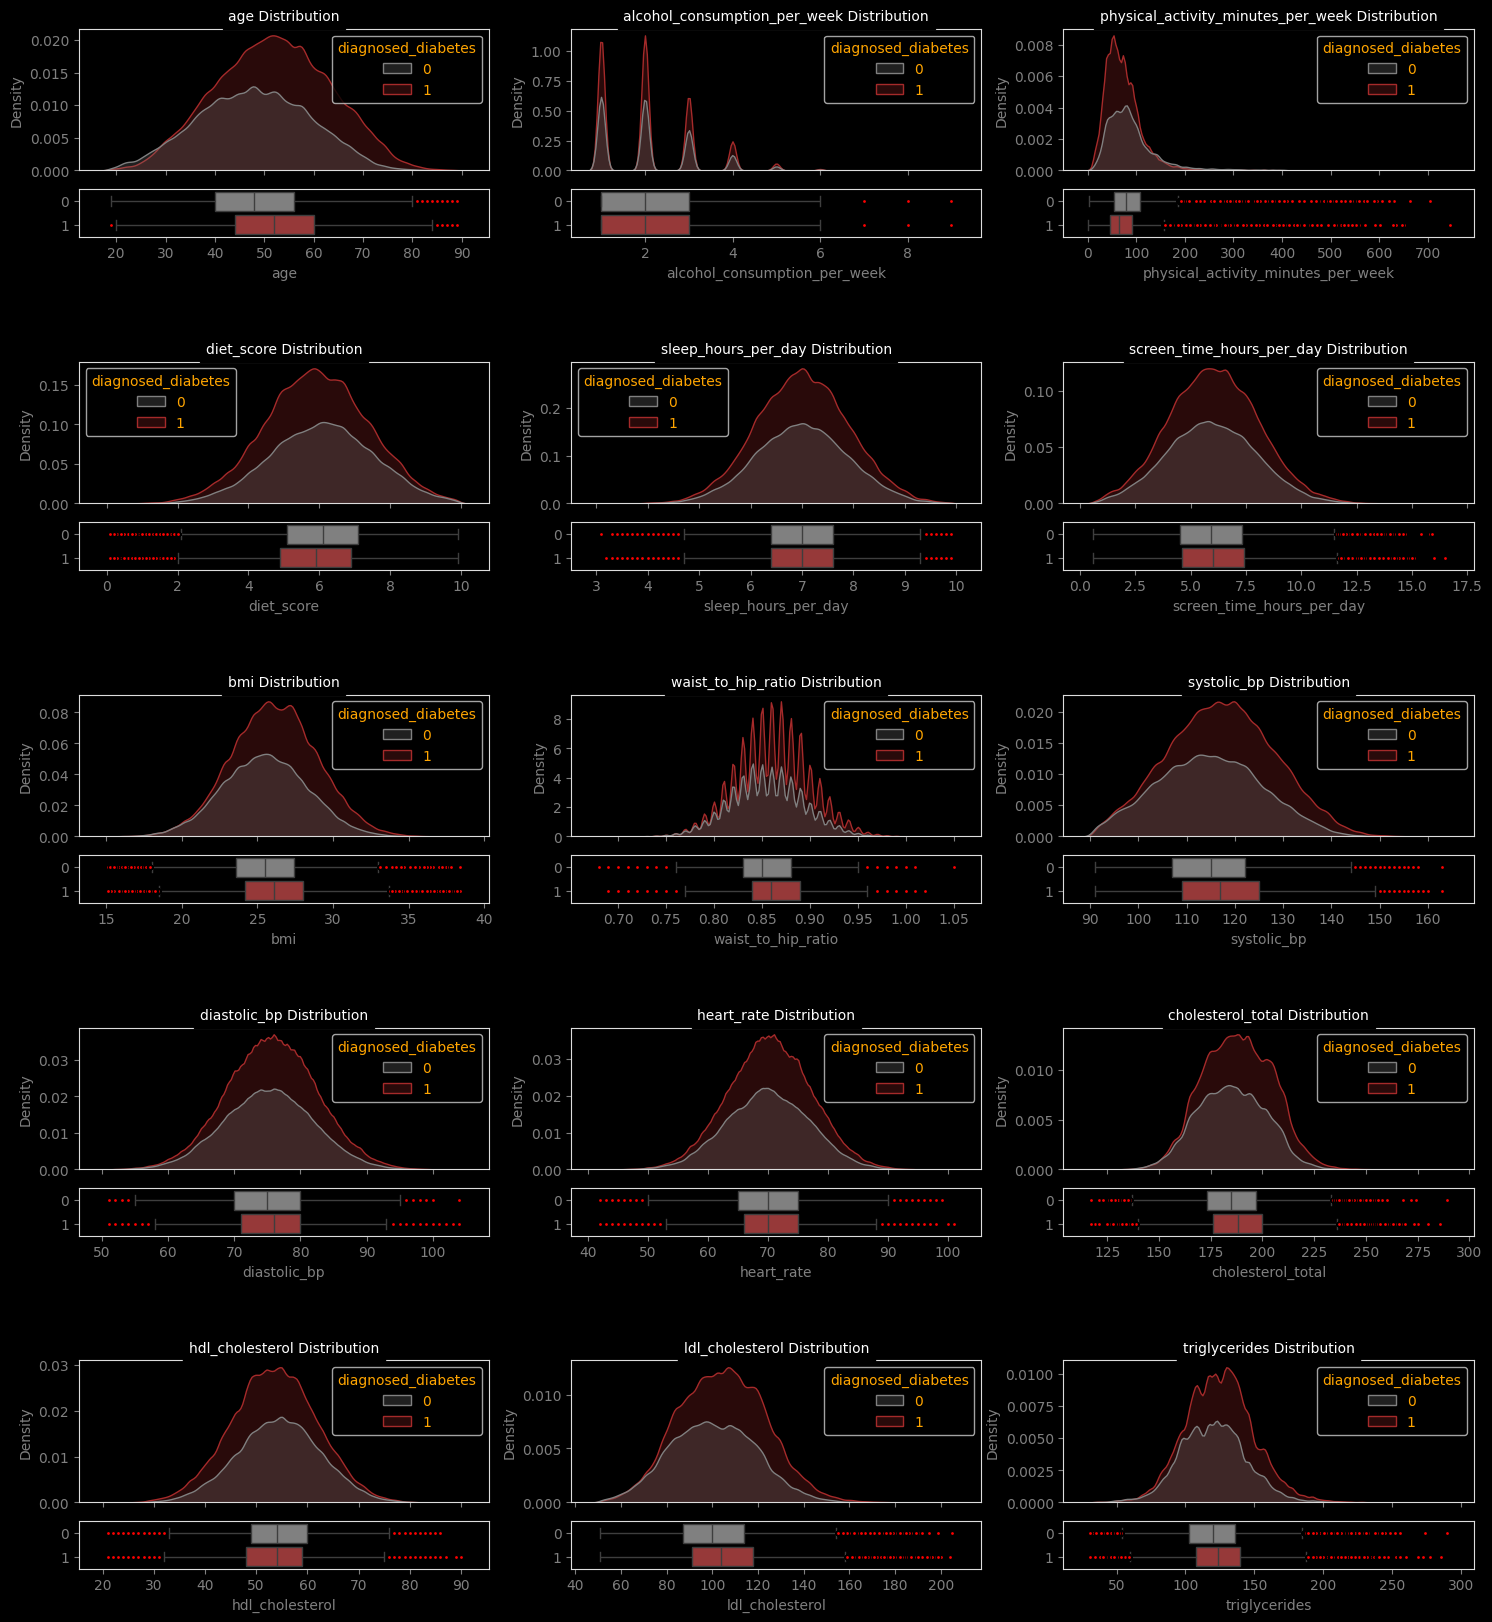

In [15]:
plot_num_distribution_grid(tr_00, grouper=target)

In [16]:
preprocess_data = True
use_cat_mapping = False


# Your mapping dictionaries
gender__dico = {'Male': -1, "Female": 1, 'Other': 0}
education_level__dico = {'No formal': 0, 'Highschool': 1, 'Graduate': 2, 'Postgraduate': 3}
smoking_status__dico = {'Never': 0, 'Former': 1, 'Current': 2}  
income_level__dico = {'Low': 0, 'Lower-Middle': 1, 'Middle': 2, 'Upper-Middle': 3, 'High': 4}
employment_status__dico = {'Unemployed': 0, 'Student': 1, 'Employed': 2, 'Retired': 3}

# Collect mappings in one place keyed by column name
cat_mappings = {
    'gender': gender__dico,
    'education_level': education_level__dico,
    'smoking_status': smoking_status__dico,    # be careful with name consistency
    'income_level': income_level__dico,
    'employment_status': employment_status__dico,
}


# Apply to each dataframe
for df in [tr_00, ts_00, or_00]:
    if preprocess_data:
        df['pysicaL_activity_*_sleep_hours🧮'] = df['physical_activity_minutes_per_week']/df['sleep_hours_per_day']
        df['sleep_hours_per_day_*_sleep_hours🧮'] = df['sleep_hours_per_day']/df['screen_time_hours_per_day']
        df['bmi_*_diet_score🧮'] = df['bmi']/df['diet_score']
        df['diastolic_*_sistolic🧮'] = df['diastolic_bp']/df['systolic_bp']
        df['bmi_*_diastolic_bp'] = df['bmi']*df['diastolic_bp']
        df['diastolic_bp-systolic_bp_*_bmi'] = (df['diastolic_bp']-df['systolic_bp'])/df['bmi']
        if use_cat_mapping:
            for col, mapping in cat_mappings.items():
                # Replace with numeric codes; keep any unknowns as-is
                df[col] = df[col].replace(mapping)
        
                # Optional: convert to nullable integer dtype (handles any non-mapped leftovers)
                # If you are sure everything maps to integers, you can use int instead.
                df[col] = df[col].astype('Int64')  # nullable integer dtype
        else:
            pass
    else:
        pass

tr_00.head(3)




,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes,pysicaL_activity_*_sleep_hours🧮,sleep_hours_per_day_*_sleep_hours🧮,bmi_*_diet_score🧮,diastolic_*_sistolic🧮,bmi_*_diastolic_bp,diastolic_bp-systolic_bp_*_bmi
id,,,,,,,,,,,,,,,,,,,,,
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,0,0,0,1,6.617647,1.114754,4.337662,0.625000,2338.0,-1.257485
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,0,0,0,1,11.230769,1.120690,4.175439,0.641667,1832.6,-1.806723
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,0,0,0,0,21.351351,0.813187,2.835294,0.936842,2144.9,-0.248963


## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > Handle Outliers in num_features </p>

In [17]:
# Define function to handle outliers
def remove_outliers(df):
    df = df.copy()
    for col in num_feats:
        if df[col].nunique()>20:
            IQR = iqr(df[col])  # calculate the interquartile range
            df[col] = np.clip(df[col], 
                              (np.quantile(df[col], 0.25) - 1.5*IQR), 
                              (np.quantile(df[col], 0.75) + 1.5*IQR)
                             ) # clip the outliers in the range (25, 75)quantile -or+ 1.5 IQ
    return df

# Remove outliers from the various datasets
tr_01 = remove_outliers(tr_00)
ts_01 = remove_outliers(ts_00)
or_01 = remove_outliers(or_00)

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 4. Model Preparation </p>

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 4.1 Fit the Model and explain the model </p>

In [18]:
X = tr_01.copy()

y = X.pop(target)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

In [20]:
# The preprocessor used to handle cat_features for xgb and voting classifiers
preprocessor = ColumnTransformer(
    transformers=[
        # ('encoder', prepro.OneHotEncoder(), cat_feats)
        # ('encoder', ce.TargetEncoder(), cat_feats)
        ('encoder', ce.HashingEncoder(), cat_feats)
    ],  
    remainder= 'passthrough',
    n_jobs=-1
)

In [21]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "num_leaves": trial.suggest_int("num_leaves", 4, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
        # "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        # "objective": "regression",
        # "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.5),
        "max_bin": trial.suggest_int("max_bin", 100, 255),
        # "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        # "importance_type": trial.suggest_categorical("importance_type", ["split", "gain"]),
        "device": "gpu"  # Uncomment if GPU is available
    }

    # the model pipeline
    model = Pipeline(
        [('preprocessor', preprocessor), 
         ('estimator', LGBMClassifier(**params, verbose=-1))]
    )

    if cv_scorer:
        # Cross-validation (recommended)
        scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        return scores.mean()
    else:
        # Alternatively
        model.fit(X_train, y_train)
        
        preds = model.predict_proba(X_valid)[:, 1]
        score = metrics.roc_auc_score(y_valid, preds)
       
        return score

In [ ]:
cv_scorer=False

def Run_Pass_lgbm_study(n_trials=1):
    if n_trials > 1:
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials, timeout=72000, show_progress_bar=True)
        best_study_params = study.best_params

        print(f"Number of finished trials: {len(study.trials)}")
        trial = study.best_trial
        print(f"Best trial auc_score: {trial.value:.6f}")
    else:
        print("No need to run Optuna, we will use the parameters obtained earlier.")
        
        # best_study_params = {'n_estimators': 470, 
        #                      'learning_rate': 0.09,
        #                      'max_depth': 5, 
        #                      'num_leaves': 256, 
        #                      # 'min_child_samples': 28, 
        #                      # 'colsample_bytree': 0.6478895973288086,
        #                      # 'subsample': 0.528816037125001, 
        #                      'reg_alpha': 1.7035182824513545, 
        #                      'reg_lambda': 0.3866741017392513, 
        #                      # 'boosting_type': 'dart', 
        #                      # 'min_split_gain': 0.4840318270120275, 
        #                      # 'max_bin': 206, 
        #                      # 'scale_pos_weight': 1.2679193621456322, 
        #                      # 'importance_type': 'split'
        #                     }
        # best_study_params = {'n_estimators': 890, 
        #                      'learning_rate': 0.6350991469818366, 
        #                      'max_depth': 2, 
        #                      'num_leaves': 98, 
        #                      'reg_alpha': 0.8291831960823974,
        #                      'reg_lambda': 0.5865654353948012
        #                     }

        best_study_params = {'n_estimators': 960, 
                             'learning_rate': 0.5019675140772736, 
                             'max_depth': 2, 
                             'num_leaves': 52,
                             'reg_alpha': 0.9945293630381706, 
                             'reg_lambda': 0.9849067535604036
                            }
        # best_study_params = {'n_estimators': 1000, 'learning_rate': 0.3621144415849586, 'max_depth': 2, 'num_leaves': 161, 'min_child_samples': 9, 'reg_alpha': 0.05642625929192206, 'reg_lambda': 0.97375978440719, 'max_bin': 182}
    
    print(f"\nBest parameters: {best_study_params}")
    return best_study_params

In [23]:
best_params = Run_Pass_lgbm_study(n_trials=100)

[I 2025-12-18 20:19:08,295] A new study created in memory with name: no-name-eb794f5b-a08a-4dc2-9e89-78770543834a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-18 20:19:32,878] Trial 0 finished with value: 0.7204092533445517 and parameters: {'n_estimators': 700, 'learning_rate': 0.03112035709571743, 'max_depth': 4, 'num_leaves': 35, 'min_child_samples': 28, 'reg_alpha': 0.787152859415221, 'reg_lambda': 0.8981374933329992, 'max_bin': 121}. Best is trial 0 with value: 0.7204092533445517.
[I 2025-12-18 20:19:53,447] Trial 1 finished with value: 0.6993714064412501 and parameters: {'n_estimators': 990, 'learning_rate': 0.9230154846035791, 'max_depth': 4, 'num_leaves': 73, 'min_child_samples': 19, 'reg_alpha': 0.519818918769431, 'reg_lambda': 0.2820443914668462, 'max_bin': 187}. Best is trial 0 with value: 0.7204092533445517.
[I 2025-12-18 20:20:17,095] Trial 2 finished with value: 0.6746097365377214 and parameters: {'n_estimators': 600, 'learning_rate': 0.6858947018027499, 'max_depth': 10, 'num_leaves': 72, 'min_child_samples': 9, 'reg_alpha': 0.5760332753229058, 'reg_lambda': 0.08397701525634656, 'max_bin': 221}. Best is trial 0 with v

In [24]:
# The estimator
lgb = LGBMClassifier(**best_params, verbose=-1)

# the model pipeline
lgb_pipe = Pipeline(
    [('preprocessor', preprocessor), 
     ('estimator', lgb)]
)

In [25]:
lgb_pipe.fit( X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('estimator', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('encoder', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [26]:
# Train model
lgb_pipe.fit(X_train, y_train)
#
lgb = lgb_pipe.named_steps['estimator']
# Get feature importance
importances_split = lgb.feature_importances_

# For gain importance:
importances_gain = lgb.booster_.feature_importance(importance_type='gain')

In [27]:
# Get the fetures names after preprocessing
feature_names = lgb_pipe[:-1].get_feature_names_out()

# Build importance dataframe
importaces = pd.DataFrame(
    {'Split_Importances': importances_split, 
     'Gain_Importances': importances_gain}, 
    index=feature_names).sort_values(by='Gain_Importances')

importaces

,Split_Importances,Gain_Importances
encoder__col_4,2,3.883618
encoder__col_6,1,5.873430
encoder__col_0,2,6.636970
encoder__col_3,6,17.768630
encoder__col_7,12,32.610797
encoder__col_2,7,34.116650
encoder__hypertension_history,6,46.447080
encoder__col_1,11,52.543650
encoder__col_5,14,68.995068
encoder__cardiovascular_history,5,89.424921


<Axes: title={'center': 'Split_Importances'}>

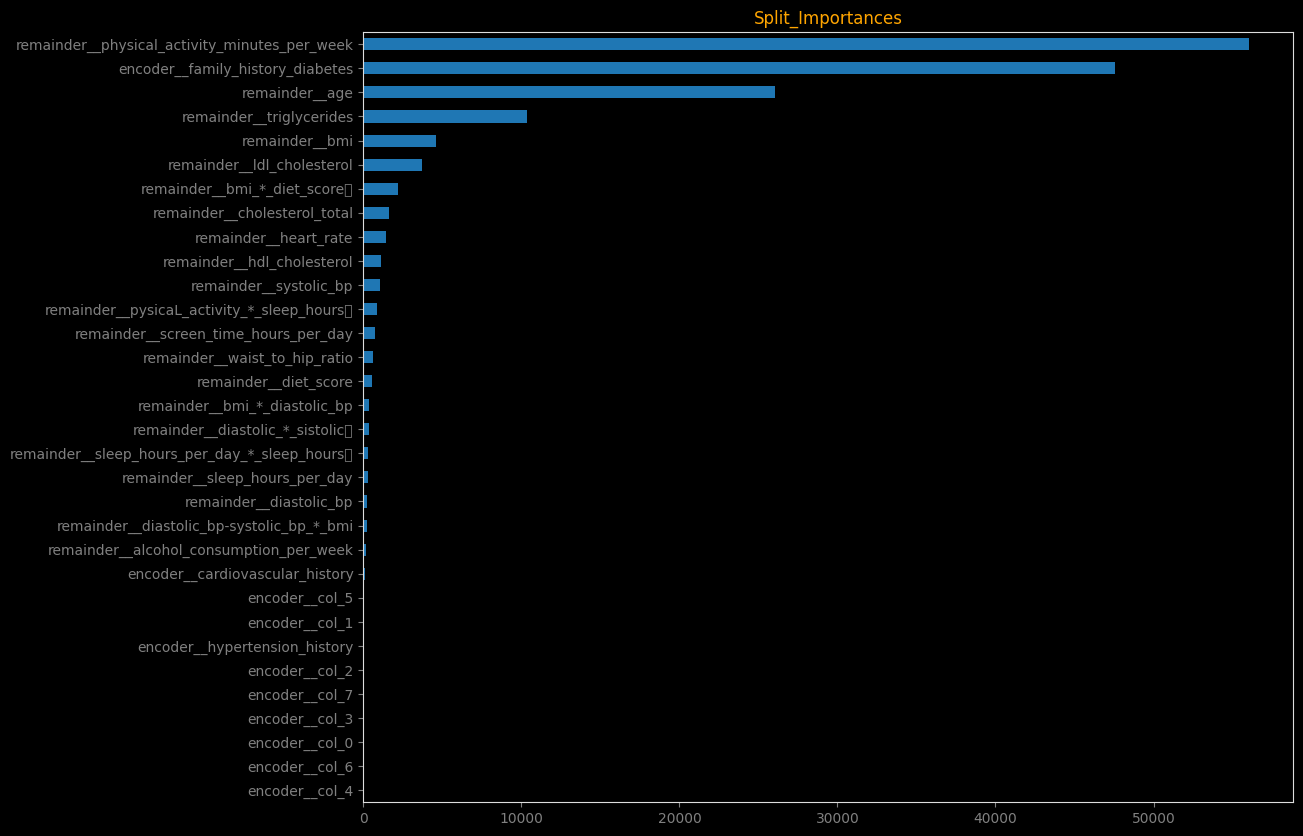

In [28]:
importaces.iloc[:, 1].plot.barh(figsize=(12, 10), title=importaces.columns[0])

<Axes: title={'center': 'Gain_Importances'}>

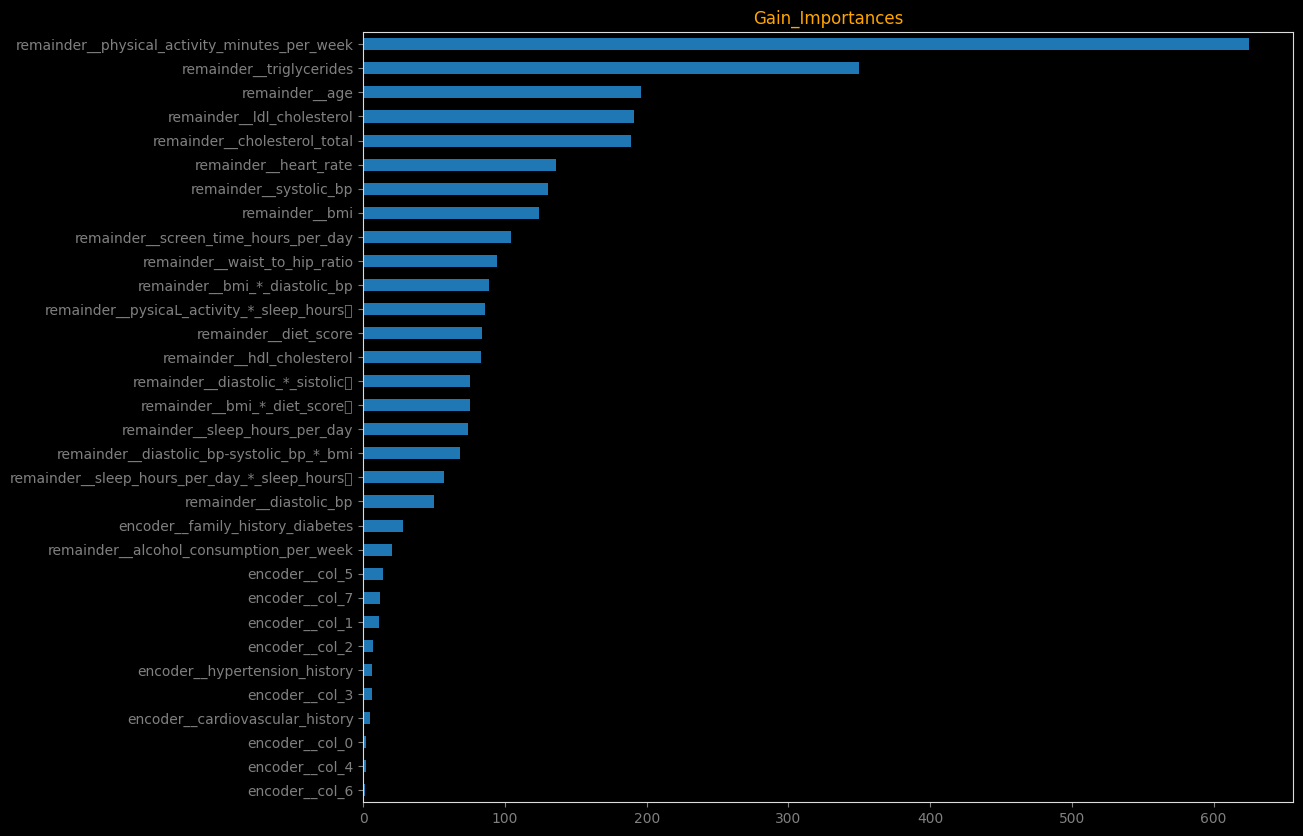

In [29]:
importaces.iloc[:, 0].sort_values().plot.barh(figsize=(12, 10), title=importaces.columns[1])

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 4.2 Crossvalidate the Model </p>

🚨🚨🚨 Working on fold_1 of 6
                               •••••> Fold_1 AUC: 0.726679 ✅

🚨🚨🚨 Working on fold_2 of 6
                               •••••> Fold_2 AUC: 0.727237 ✅

🚨🚨🚨 Working on fold_3 of 6
                               •••••> Fold_3 AUC: 0.727957 ✅

🚨🚨🚨 Working on fold_4 of 6
                               •••••> Fold_4 AUC: 0.729603 ✅

🚨🚨🚨 Working on fold_5 of 6
                               •••••> Fold_5 AUC: 0.728446 ✅

🚨🚨🚨 Working on fold_6 of 6
                               •••••> Fold_6 AUC: 0.728270 ✅



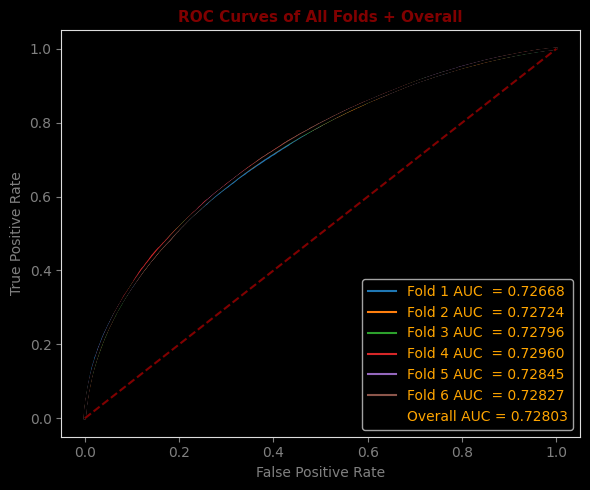

In [30]:
seed=1087
n_splits = 6
spliter = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Store out-of-fold predictions
oof_preds = []
oof_true = []

plt.figure(figsize=(6, 5))      
for f, (tr_ind, va_ind) in enumerate(spliter.split(X, y), 1):
    print(f'🚨🚨🚨 Working on fold_{f} of {n_splits}')
    X_tr, X_va = X.iloc[tr_ind], X.iloc[va_ind]
    y_tr, y_va = y.iloc[tr_ind], y.iloc[va_ind]

    # Clone the model before fitting
    clf = clone(lgb_pipe)
    clf.fit(X_tr, y_tr)

    preds = clf.predict_proba(X_va)[:, 1]

    # Save for overall ROC
    oof_preds.extend(preds)
    oof_true.extend(y_va)

    # Per-fold AUC
    score = metrics.roc_auc_score(y_va, preds)
    print(30*' ',f'•••••> Fold_{f} AUC: {score:.6f} ✅\n')

    # Per-fold ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_va, preds)
    plt.plot(fpr, tpr, label=f'Fold {f} AUC  = {score:.5f}')

# Overall ROC curve
overall_auc = metrics.roc_auc_score(oof_true, oof_preds)
fpr, tpr, _ = metrics.roc_curve(oof_true, oof_preds)
plt.plot(fpr, tpr, color='black', linewidth=2,
         label=f'Overall AUC = {overall_auc:.5f}')

# Diagonal baseline
plt.plot([0, 1], [0, 1], color='maroon', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curves of All Folds + Overall', 
          color='maroon', fontsize=11, weight='bold')
plt.tight_layout()
plt.show()

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color: #A52A2A; border-radius:15px; font-size:100%; text-align:left;padding:10px; background: black; border-top: 5px solid black; border-left: 10px solid black" > 4.3 Prediction on test data and submission </p>

In [31]:
sb_00[target] = lgb_pipe.predict_proba(ts_01)[:,1]

sb_00.head()

,id,diagnosed_diabetes
0,700000,0.477522
1,700001,0.692491
2,700002,0.766288
3,700003,0.392463
4,700004,0.927392


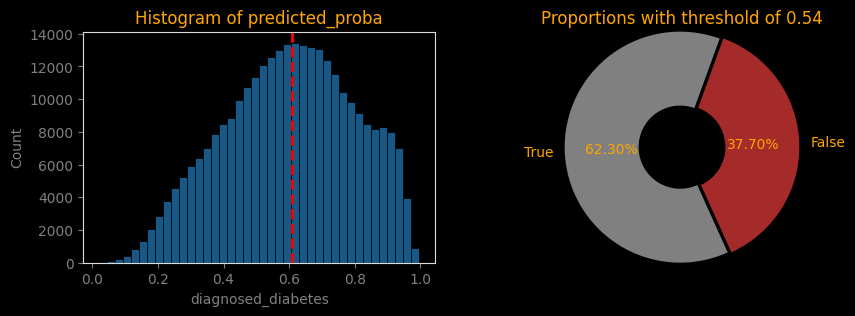

In [32]:
threshold = 0.54

plt.figure(figsize=(10, 3))
plt.subplot(121)
sns.histplot(sb_00, x=target, bins=40)
plt.axvline(x=sb_00[target].median(), color='r', linestyle='--', linewidth=2)
plt.title('Histogram of predicted_proba')
plt.subplot(122)
(sb_00[target]>threshold).value_counts().plot.pie(
    radius=1.25,
    autopct='%.2f%%',
    startangle=70,
    wedgeprops={'width': 0.8},
    explode=[0.02, 0.02],
    colors=target_colors,
    title=f'Proportions with threshold of {threshold }'
)
plt.ylabel('')
plt.show()

In [33]:
sb_00.to_csv('submission.csv', index=False)
print('The file is ready for submission ✅')

The file is ready for submission ✅
